# Quick Start Guide

This tutorial shows how to quickly get started using *scarlet* to model an hyperspectral image cube. For a more in-depth introduction to *scarlet*, read our [User Guide](user_docs.ipynb).

In order to run this tutorial you will need either `astropy` (http://www.astropy.org) or `sep` (https://github.com/kbarbary/sep) installed to open/create the source catalog and `matplotlib` (https://matplotlib.org) to display the images

In [1]:
# Import Packages and setup
import logging
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)
logger = logging.getLogger("proxmin")
logger.setLevel(logging.DEBUG)


import autograd.numpy as np
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

## Load and display the sample data

In [2]:
# Load the sample images
data = np.load("../data/hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
catalog = data["catalog"]
weights = 1/data["variance"]
psfs = scarlet.PSF(data["psfs"])

### Display a raw image cube
This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sinh^{-1}$ function to normalize the flux in each filter consistently to create an RGB image.

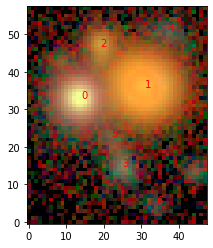

In [3]:
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping

stretch = 0.1
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)

# Mark all of the sources from the detection cataog
for k, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(k), color="red")

## Define the model frame and the observation

A `Frame` in *scarlet* is a description of the hyperspectral cube of the model or the observations. Think of it as the metadata, what aspects of the sky are described here. For observations, most of those are contained in FITS headers. At the least, a `Frame` holds the `shape` of the cube, for which we use the convention `(C, Ny, Nx)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `Ny, Nx` for the number of pixels at every channel.

Additionally, you can and often must provide weights for all elements in the data cube, an image cube of the PSF model (one image for all or one for each channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

In this example, we assume that bands and pixel locations are identical between the model and the observation. But we have ground-based images with different PSFs in each band, so we need to provide a reference PSF for the model. We simply choose a minimal Gaussian PSF that is barely well sampled and use it as our reference kernel:

In [4]:
from functools import partial
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8))

With this we can fully specify the `Frame` and the `Observation`. Think of the latter as a `Frame` with a data portion.

In [5]:
model_frame = scarlet.Frame(images.shape, psf=model_psf, channels=filters)
observation = scarlet.Observation(images, psf=psfs, weights=weights, channels=filters).match(model_frame)

The previous command calls the `match` method to compute e.g. PSF difference kernel and filter transformations.

## Initialize the sources

You now need to define sources that are going to be fit. The full model, which we call `Blend` is a collection of those sources.

Each source is derived from `scarlet.Component` or from `scarlet.ComponentTree` in case of a multi-component source. We provide several pre-built source types:

* `scarlet.PointSource` fits centers and per-band amplitude using the observed PSF model.
* `scarlet.ExtendedSource` fits per-band amplitude and a non-parametric morphology (which can be constrained to be symmetric and/or monotonic with respect to the center).
* `scarlet.MultiComponentSource` splits an `ExtendedSource` into multiple components that are initially radially separated.

In our example, we assume *prior* knowledge that object 0 is a star, and object 1 should be modeled as a bulge-disc model. Everything else is assumed a galaxy.

In [6]:
sources = []
for k,src in enumerate(catalog):
    if k == 0:
        new_source = scarlet.PointSource(model_frame, (src['y'], src['x']), observation)
    elif k == 1:
        new_source = scarlet.MultiComponentSource(model_frame, (src['y'], src['x']), observation, symmetric=False, monotonic=True, thresh=5)
    else:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation, symmetric=False, monotonic=True, thresh=5)
    sources.append(new_source)

## Create and fit the model
The `scarlet.Blend` class represent the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

Solution did not converge


CPU times: user 6.2 s, sys: 43.7 ms, total: 6.24 s
Wall time: 1.57 s
scarlet ran for 78 iterations to logL = 30177.54918538728


Text(0, 0.5, 'log-Likelihood')

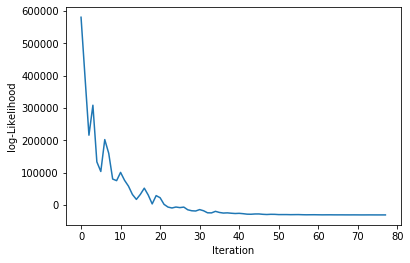

In [7]:
blend = scarlet.Blend(sources, observation)
%time blend.fit(200)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(blend.loss)
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')

## View the results

### View the full model
First we load the model for the entire blend, render it in the observation frame, and compute its residuals. We then show model and date with the same $sinh^{-1}$ stretch and the residuals with a linear stretch.

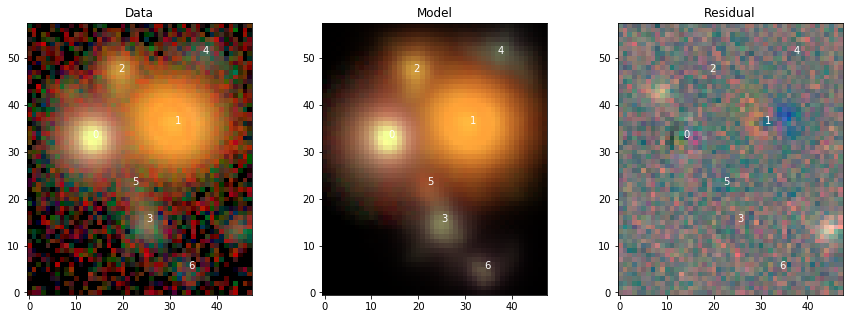

In [8]:
# Load the model and calculate the residual
model = blend.get_model()
model_ = observation.render(model)
residual = images-model_
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend):
    y,x = component.center
    ax[0].text(x, y, k, color="w")
    ax[1].text(x, y, k, color="w")
    ax[2].text(x, y, k, color="w")
plt.show()

### View the source models
We will now inspect the model for each source, in its original frame and in its observed frame. In this example, the two frames differ by an extra convolution from the minimal `model_psf` to the observed psfs.

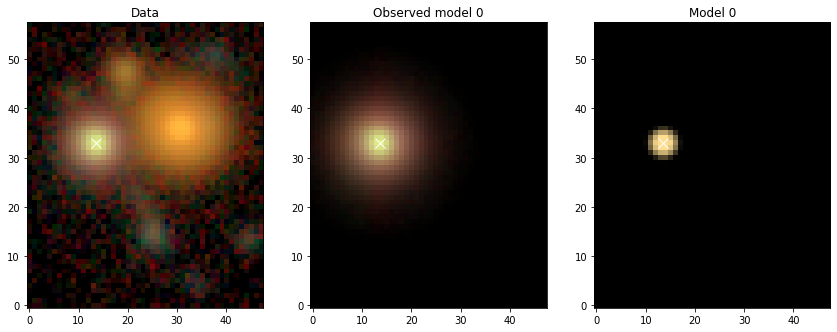

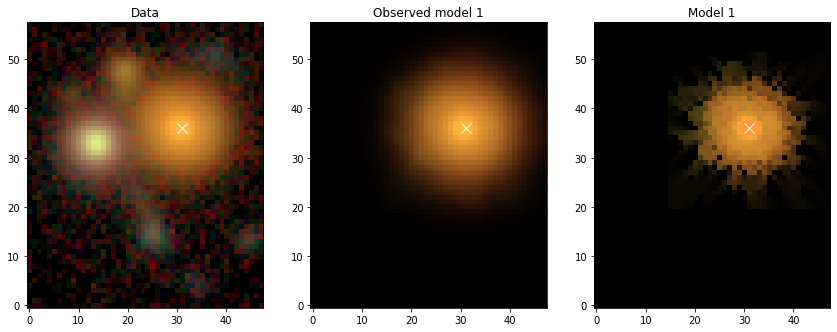

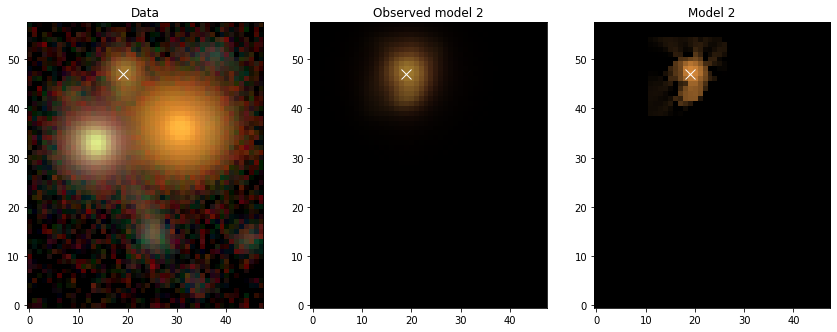

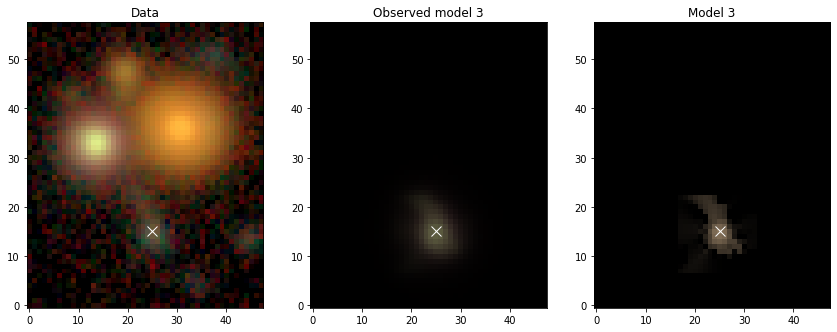

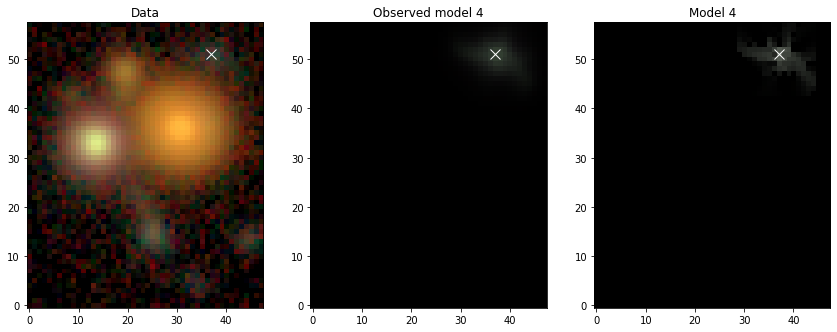

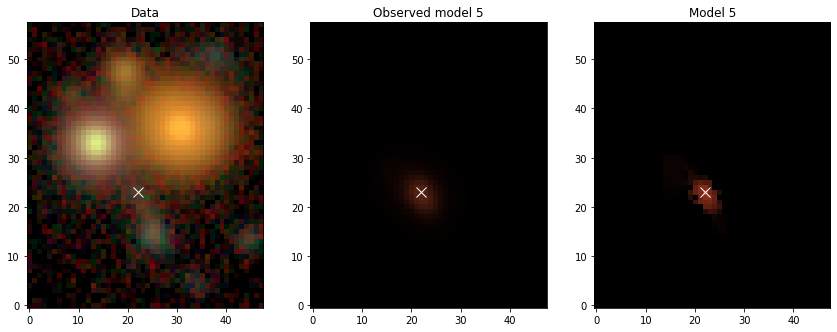

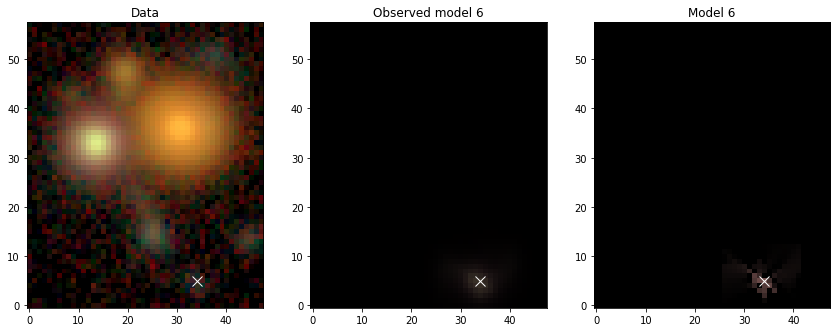

In [9]:
# Set the stretch based on the model
stretch = .3
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

for k,src in enumerate(sources):
    # Get the model for a single source
    model = src.get_model()
    model_ = observation.render(model)
    
    # Convert observation and models to RGB
    img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
    model_rgb = scarlet.display.img_to_rgb(model, norm=norm)
    model_rgb_ = scarlet.display.img_to_rgb(model_, norm=norm)

    # Set the figure size
    ratio = src.frame.shape[2]/src.frame.shape[1]
    fig_height = 3*src.frame.shape[1]/20
    fig_width = max(2*fig_height*ratio,2)
    fig = plt.figure(figsize=(fig_width, fig_height))
    
    # Generate and show the figure
    ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
    ax[0].imshow(img_rgb)
    ax[0].set_title("Data")
    ax[1].imshow(model_rgb_)
    ax[1].set_title("Observed model {0}".format(k))
    ax[2].imshow(model_rgb)
    ax[2].set_title("Model {0}".format(k))
    # Mark the source in the data image
    y,x = src.center
    ax[0].plot(x, y, "wx", mew=1, ms=10)
    ax[1].plot(x, y, "wx", mew=1, ms=10)
    ax[2].plot(x, y, "wx", mew=1, ms=10)
    plt.show()

We can see that the model of object 0 assumes a simple Gaussian shape, which is the internal representation of a point source. It also shows the effective PSF of all the other models. Source 1 uses the freedom of the 2-compoent model to represent a slightly redder core.

### SEDs and Fluxes

We can further get the per-band fluxes of all objects. The convention of these fluxes is given by the units and ordering of the original data cube. In the case of multi-component sources, the fluxes are combined.

In [10]:
for k, src in enumerate(sources):
    model = src.get_model()
    print ("Source {}, Fluxes: {}".format(k, scarlet.measure.flux(model)))

Source 0, Fluxes: [167.03679401 264.28556159 319.81247544 347.43357894 369.69949415]
Source 1, Fluxes: [ 75.13583591 215.99944874 388.76762248 521.30121289 644.3476339 ]
Source 2, Fluxes: [ 8.16366096 12.55454017 24.49979321 31.08505291 40.13339022]
Source 3, Fluxes: [ 8.27966063  9.5486718  11.08556869 12.79846145 13.2673125 ]
Source 4, Fluxes: [4.90533494 4.97002833 5.72266336 5.37254538 4.91770202]
Source 5, Fluxes: [1.06990223 1.24432484 2.0742733  2.24167304 8.34486084]
Source 6, Fluxes: [2.56275464 2.29701562 2.44809324 3.03469484 4.02147379]


### Parameters and Errors

Internally, `Blend` solves an optimization problem, namely reducing the loss by adjusting the parameters of each component. The loss is the log-likelihood of the observed data given the model. Every component can declare its own parameters, which we can access by with the `parameters` property:

In [11]:
for k,src in enumerate(sources):
    for p in src.parameters:
        print ("Source {}, Parameter shape {}, Converged {}".format(k, p.shape, p.converged))

Source 0, Parameter shape (5,), Converged True
Source 0, Parameter shape (2,), Converged True
Source 1, Parameter shape (5,), Converged False
Source 1, Parameter shape (32, 32), Converged False
Source 1, Parameter shape (5,), Converged False
Source 1, Parameter shape (32, 32), Converged False
Source 2, Parameter shape (5,), Converged True
Source 2, Parameter shape (16, 16), Converged False
Source 3, Parameter shape (5,), Converged True
Source 3, Parameter shape (16, 16), Converged False
Source 4, Parameter shape (5,), Converged False
Source 4, Parameter shape (16, 16), Converged False
Source 5, Parameter shape (5,), Converged False
Source 5, Parameter shape (16, 16), Converged False
Source 6, Parameter shape (5,), Converged False
Source 6, Parameter shape (16, 16), Converged False


The parameter with length 5 is the SED, while the other describes the morphology. For object 0, this is simple a 2D center, the rest use images of different sizes.

Each parameter is a souped up numpy array. It has attributes that store any constraints that were enforced during optimization, whether this parameter is considered converged, and an error estimate. In our example, several parameters have converged within relative changes of `e_rel=1e-3` (the default setting of `Blend.fit`), but others have not. This is why the fitter complained about non-convergence. The run above stopped because the loss did not change noticeably anymore.

To demonstrate the use of error estimate, we make a signal-to-noise map of the morphology of source 5:

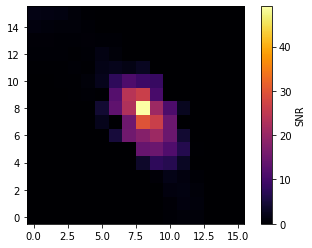

In [12]:
p = sources[5].parameters[1]
plt.imshow(p / p.std)
plt.colorbar(label='SNR')

The SNR map shows that the center region is well determined by the data. However, this error estimate is purely statistical and does not include correlations between different parameters or different components. In fact, there's an upper lobe in the top-left corner of this source that is part of source 0. The gradient optimizer would exploit that and increase the morphology values there, but the monotonicity constraint has largely prevented that.